# Graph Overflow

Group 5

- Asger Laurits Schultz
- August Semrau Andersen
- Andreas Hornemann Nielsen

## Table of contents

- 1. Motivation
- 2. Data
- 3. Analysis
    - 3.1. Stack Overflow as a Graph
    - 3.2. Sentiment Analysis and Loved Languages
    - 3.3. Building a Language Classifier Using TF-IDF
- 4. Discussion

## 1. Motivation

### - What is your dataset?
Our dataset consists of 1.3 million submissions, that is questions, answers and comments, publicly available on Stack Overflow.  
These submissions share a few characteristics:
 - They are tagged with one of 16 programming languages.
 - They were submitted earliest 2015 up until now. The data spans this period of time uniformly.
 - The contain (anonomous) id on the user/author of each submission, as well as the parent user/author in the case of answers to uestions or comments to questions or answers.  

### - Why did you choose this/these particular dataset(s)?

### - What was your goal for the end user's experience?

## 2. Data

## - Write about your choices in data cleaning and preprocessing

## - Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

Our data consists of a subset of Stack Overflow threads spanning 2015-2019.
We have selected the following 16 widely used programming languages to focus on: Rust, TypeScript, Python, Kotlin, Go, Dart, C#, JavaScript, Haskell, Java, C++, Ruby, C, Perl, Objective-C, and VBA.

For each week in the period, we download up to 100 threads for each language including the question itself, all answers, and all comments, as well as information about the authors.
The data is collected using the <a href="https://pypi.org/project/stackapi">StackAPI</a> wrapper for the <a href="https://api.stackexchange.com/">Stack Excange API</a>.
Due to throttling limitations, the data was downloaded over multiple days using the following script.
This should give a representative sample within each language.

In [2]:
%%script false --no-raise-error
from __future__ import annotations
import os
import sys
import datetime as dt
import json
import math
from typing import Any

import click
import pandas as pd
import stackapi
from pelutils import log, Levels
from tqdm import tqdm

# Fetch data from five years
DAY_INTERVAL = 7
START_DATE = dt.datetime(2015, 1, 1)
END_DATE = dt.datetime(2020, 1, 1)

SITE = stackapi.StackAPI("stackoverflow")
SITE.max_pages = 1
N_REQUESTS = math.ceil((END_DATE - START_DATE).days / DAY_INTERVAL)
assert N_REQUESTS < 300

def _get_by_nested_keys(d: dict, keys: list[str]) -> tuple[str, Any]:
    if len(keys) == 1:
        return d.get(keys[0])
    else:
        return _get_by_nested_keys(d[keys[0]], keys[1:])

def get_data(language: str) -> pd.DataFrame:

    os.makedirs(os.path.join("data", language), exist_ok=True)
    log.section("Getting data for %s from %s to %s" % (language, START_DATE.date(), END_DATE.date()-dt.timedelta(days=1)))
    log("Using %i requests" % N_REQUESTS)
    quota_remaing = 300
    questions = list()

    start, end = START_DATE, START_DATE + dt.timedelta(days=DAY_INTERVAL)
    for i in tqdm(range(N_REQUESTS)):
        r = SITE.fetch(
            "questions",
            fromdate=start,
            todate=end,
            tagged=language,
            sort="creation",
            filter="!)PBt)ZX9Bm(JUgw*DM)sjdIE*XsapktUmLzYx2hZO*0Ucza8VQCedEvwmjgs5h_VvaGrwX",
        )
        quota_remaing = r["quota_remaining"]
        questions += r["items"]
        # Save fetched data
        with open(os.path.join("data", language, "response_%i.json" % i), "w") as f:
            json.dump(r["items"], f)

        start += dt.timedelta(days=DAY_INTERVAL)
        end += dt.timedelta(days=DAY_INTERVAL)
        if start >= END_DATE:
            break
        elif end > END_DATE:
            end = END_DATE

    log("Got %i responses" % len(questions), "Remaining quota: %i" % quota_remaing)

    # Save useful things from response
    log.section("Extracting useful data")
    useful_question_keys = { "title", "body", "view_count", "score", "creation_date", "link",
        "question_id", "owner/user_id", "owner/reputation" }
    useful_answer_keys = { "body", "creation_date", "score", "owner/user_id", "owner/reputation", "answer_id" }
    useful_comment_keys = useful_answer_keys
    filtered_questions, filtered_answers, filtered_comments = list(), list(), list()
    for _, q in tqdm(enumerate(questions)):
        filtered_questions.append({
            "language": language,
            **{ key: str(_get_by_nested_keys(q, key.split("/"))) for key in useful_question_keys if key in q or "/" in key }
        })
        for answer in q.get("answers", list()):
            filtered_answers.append({
                "language": language,
                "question_id": str(q["question_id"]),
                **{ key: str(_get_by_nested_keys(answer, key.split("/"))) for key in useful_answer_keys if key in answer or "/" in key }
            })
            for comment in answer.get("comments", list()):
                filtered_comments.append({
                    "language": language,
                    "question_id": str(q["question_id"]),
                    "answer_id": str(answer["answer_id"]),
                    **{ key: str(_get_by_nested_keys(comment, key.split("/"))) for key in useful_comment_keys if key in comment or "/" in key },
                })
        for comment in q.get("comments", list()):
            filtered_comments.append({
                "language": language,
                "question_id": str(q["question_id"]),
                **{ key: str(_get_by_nested_keys(comment, key.split("/"))) for key in useful_comment_keys if key in comment or "/" in key },
            })

    df = pd.DataFrame(filtered_questions)
    q_path = os.path.join("data", language, "questions.pkl")
    df.to_pickle(q_path)
    log("Saved %i questions to %s" % (len(df), q_path))
    del df

    df = pd.DataFrame(filtered_answers)
    a_path = os.path.join("data", language, "answers.pkl")
    df.to_pickle(a_path)
    log("Saved %i answers to %s" % (len(df), a_path))
    del df

    df = pd.DataFrame(filtered_comments)
    c_path = os.path.join("data", language, "comments.pkl")
    df.to_pickle(c_path)
    log("Saved %i comments to %s" % (len(df), c_path))
    del df

@click.command()
@click.argument("language")
def run(language: str):
    path = os.path.join("data", "%s-questions.pkl" % language)
    if os.path.exists(path):
        cont = log.bool_input(log.input("%s eksisterer allerede. Vil du fortsætte alligevel? [j/n] " % path), default=False)
        if not cont:
            sys.exit()
    get_data(language.lower())

if __name__ == "__main__":
    with log.log_errors:
        log.configure("local_data.log", "Fetching data", print_level=Levels.DEBUG)
        run()

The downloaded data is then converted into a single, large dataframe containing all submissions.
Because of the large amount of data, half is removed, as memory would otherwise be a serious constraint.
This is done by thread basis.
Half of all question ID's are randomly selected, and submissions with that ID are removed.

In [2]:
from __future__ import annotations
import os
import pandas as pd
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
import itertools
import random
import json
import pickle
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("font", size=16)
mpl.rcParams["font.family"] = "Liberation Serif"

In [3]:
# Selected language and how loved they were according to the 2020 Stack Overflow developer survey
loved_languages = {
    "rust":        86.1,
    "typescript":  67.1,
    "python":      66.7,
    "kotlin":      62.9,
    "go":          62.3,
    "dart":        62.1,
    "c#":          59.7,
    "javascript":  58.3,
    "haskell":     51.7,
    "java":        44.1,
    "c++":         43.4,
    "ruby":        42.9,
    "c":           33.1,
    "perl":        28.6,
    "objective-c": 23.4,
    "vba":         19.6,
}

In [3]:
# Collect all data into single dataframe
qdfs = list()
adfs = list()
cdfs = list()
for lang in tqdm(loved_languages):
    qf = os.path.join("data", lang, "questions.pkl")
    af = os.path.join("data", lang, "answers.pkl")
    cf = os.path.join("data", lang, "comments.pkl")
    qdfs.append(pd.read_pickle(qf))
    qdfs[-1]["language"] = lang
    qdfs[-1]["type"] = "q"
    adfs.append(pd.read_pickle(af))
    adfs[-1]["language"] = lang
    adfs[-1]["type"] = "a"
    cdfs.append(pd.read_pickle(cf))
    cdfs[-1]["language"] = lang
    cdfs[-1]["type"] = "c"

# Shuffle to prevent systematic biases in contiguous subsets of dataframe
so = pd.concat(qdfs + adfs + cdfs, ignore_index=True).sample(frac=1)
del qdfs, adfs, cdfs

# Remove half of data, as there is otherwise too much to handle
qids = { qid for qid in set(so.question_id) if random.random() > 0.5 }
so = so[so.question_id.isin(qids)]
# Convert unix timestamps to datetime objects
so["created"] = [dt.datetime.utcfromtimestamp(ts) for ts in so["creation_date"]]
del so["creation_date"]

100%|██████████| 16/16 [00:02<00:00,  6.49it/s]


In [4]:
# Data summary
t = Table()
t.add_header(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in tqdm(loved_languages):
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print("Number of submissions in dataset")
print(t)

100%|██████████| 16/16 [00:11<00:00,  1.44it/s]

Number of submissions in dataset
Language    | Questions | Answers | Comments | Total    
------------+-----------+---------+----------+----------
Rust        |     6,575 |   8,056 |   25,032 |    39,663
Typescript  |    12,013 |  17,575 |   44,835 |    74,423
Python      |    13,051 |  18,211 |   52,057 |    83,319
Kotlin      |     8,168 |  12,670 |   29,902 |    50,740
Go          |    13,023 |  17,395 |   47,401 |    77,819
Dart        |     5,990 |   9,720 |   21,042 |    36,752
C#          |    13,096 |  16,487 |   60,692 |    90,275
Javascript  |    12,976 |  18,161 |   54,410 |    85,547
Haskell     |    10,885 |  15,129 |   51,018 |    77,032
Java        |    12,885 |  16,937 |   53,067 |    82,889
C++         |    12,961 |  17,566 |   81,105 |   111,632
Ruby        |    13,049 |  18,068 |   52,658 |    83,775
C           |    13,036 |  19,960 |   93,663 |   126,659
Perl        |     9,893 |  15,657 |   55,588 |    81,138
Objective-c |    11,830 |  14,546 |   47,432 |    73,80

With the data nicely collected, we clean it.
As we need it for different purposes, this is done in two different ways for the sentiment analysis and classifier that will be introduced in later sections.
The text bodies are raw HTML, so tags (but not their contents) are removed.
Stopwords and links are also removed.

For the sentiment analysis, we remove all code, as code is not expected to carry sentiment.
This is not done for the classifier, as keywords and naming conventions should provide strong classification features.
However, all non alphanumeric characters are removed, as this is not expected to aid in classification.
These characters are kept for the sentiment analysis, as <a href="https://pypi.org/project/vader-sentiment/">VADER</a>, the used sentiment analysis tool, takes punctuation into account.

In [5]:
# Regex for matching stopwords
sw = r"\b(" + "|".join(stopwords.words("english")) + r")\b"

def cclean(text: str) -> str:
    """ Cleaning for classification """
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    # Remove everything that is not alpha-numeric
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

def sclean(text: str) -> str:
    """ Cleaning for sentiment analysis """
    # Remove code
    text = re.sub(r"<pre><code>.*<\/pre><\/code>", "", text)
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    return text.lower()

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("Before cleaning")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

print("\nCleaning text for classification")
so["cclean"] = [cclean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.cclean)
chars = sum(len(body) for body in so.cclean)
print("\nAfter cleaning for classification")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

print("\nCleaning text for sentiment analysis")
so["sclean"] = [sclean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.sclean)
chars = sum(len(body) for body in so.sclean)
print("\nAfter cleaning for classification")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

# Save prepared data for later use
so.to_pickle("data.pkl")

  0%|          | 905/1267631 [00:00<02:20, 9035.73it/s]

Before cleaning
  Words:               85,850,491
  Avg. per submission: 67.73
  Characters:          701,927,354
  Avg. per submission: 553.73

Cleaning text for classification


  0%|          | 1039/1267631 [00:00<02:01, 10383.94it/s]


After cleaning for classification
  Words:               51,382,996
  Avg. per submission: 40.53
  Characters:          471,432,962
  Avg. per submission: 371.90

Cleaning text for sentiment analysis


100%|██████████| 1267631/1267631 [01:51<00:00, 11363.95it/s]



After cleaning for classification
  Words:               58,433,958
  Avg. per submission: 46.10
  Characters:          528,329,161
  Avg. per submission: 416.78


In [4]:
so = pd.read_pickle("data.pkl")
so

,language,owner/reputation,creation_date,title,view_count,question_id,owner/user_id,link,score,body,type,answer_id,cclean,sclean
1398899,c#,5975,1535573254,NaN,NaN,52085019,187365,NaN,1,it depends on your scenario. if a user can on...,c,52085168,depends scenario user edit records y...,depends scenario. user edit / records ...
2138304,c,606,1518090544,NaN,NaN,48667995,1864036,NaN,0,"@tilz0R That&#39;s understood. Sadly, that can...",c,NaN,tilz0r that39 understood sadly case tirt...,"@tilz0r that&#39; understood. sadly, case..."
105366,dart,596,1424094107,Published Getter and Setter in Dart,60,28542789,4112512,https://stackoverflow.com/questions/28542789/p...,0,<p>I've got two Custom Elements. The first (<c...,q,NaN,i got two custom elements the first wrapelem ...,i' got two custom elements. the first (wrap-el...
310996,perl,710,1527418709,regex to remove everything after the last comm...,3930,50551426,9218410,https://stackoverflow.com/questions/50551426/r...,0,<p>I would like to write a regex in Perl which...,q,NaN,i would like write regex perl remove ever...,i would like write regex perl remove ever...
1326650,c#,50,1442501292,NaN,NaN,32619735,4461921,NaN,0,"Unfortunately, the AddDays method isn&#39;t su...",c,32619762,unfortunately adddays method 39 supported e...,"unfortunately, adddays method &#39; supported..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361465,vba,485,1554882307,Powerpoint: Linking Excel charts &amp; updatin...,23,55607293,10602575,https://stackoverflow.com/questions/55607293/p...,0,<p>I have a PowerPoint presentation containing...,q,NaN,i powerpoint presentation containing excel c...,i powerpoint presentation containing excel c...
1633122,haskell,61,1560594967,NaN,NaN,56470015,4360704,NaN,0,I really appreciate the help everyone. This on...,c,56470115,i really appreciate help everyone this one r...,i really appreciate help everyone. this one ...
1477934,javascript,17789,1487199383,NaN,NaN,42261632,321785,NaN,0,Perhaps you mean arbitrary-length arguments li...,c,NaN,perhaps mean arbitrarylength arguments list i...,perhaps mean arbitrary-length arguments list ...
421944,python,895,1442438663,NaN,NaN,32618712,5120411,NaN,0,<p>Lets break this down:</p>\n\n<pre><code>(n ...,a,32618995,lets break \n\nn parity n amp 1\n\n\nn amp ...,lets break :\n\n(n += (parity != (n &amp; 1))...


With the data cleaned, let's understand it better. First we look at the distribution of submission sizes, and how the cleaning affected it.

<ipython-input-5-dc65a7c6065a>:1: RuntimeWarning: divide by zero encountered in log10
  def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
<ipython-input-5-dc65a7c6065a>:1: RuntimeWarning: divide by zero encountered in log10
  def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):


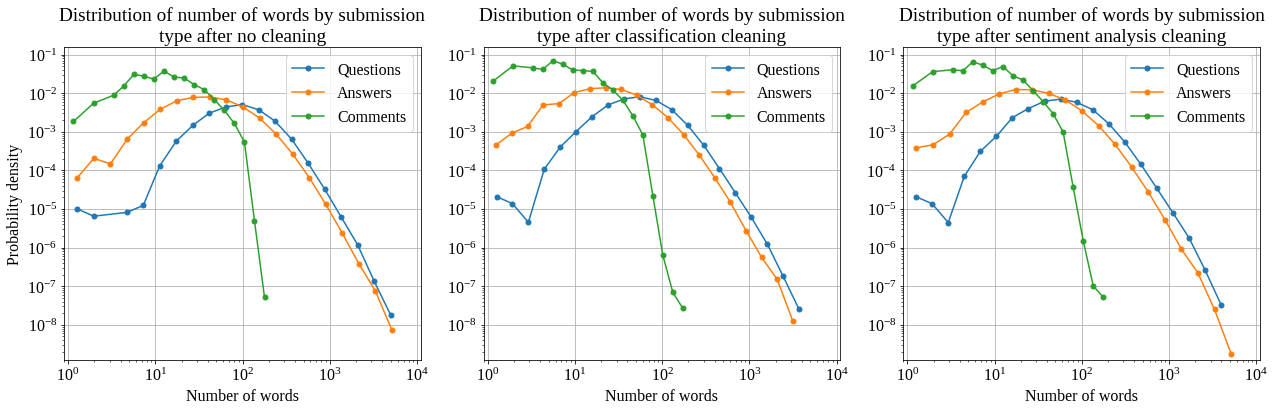

In [5]:
def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
    """ Bins data accourding to spacing function and number of given bins """
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, (lab, dat) in enumerate(zip(("No cleaning", "Classification cleaning", "Sentiment analysis cleaning"), (so.body, so.cclean, so.sclean))):
    ax_ = axs[i]
    # Plot distribution of words
    qx, qdist = bins(np.array([len(text.split()) for text in dat[so.type=="q"]]))
    ax, adist = bins(np.array([len(text.split()) for text in dat[so.type=="a"]]))
    cx, cdist = bins(np.array([len(text.split()) for text in dat[so.type=="c"]]))

    ax_.plot(qx, qdist, marker=".", ms=10, label="Questions")
    ax_.plot(ax, adist, marker=".", ms=10, label="Answers")
    ax_.plot(cx, cdist, marker=".", ms=10, label="Comments")
    ax_.grid()
    ax_.set_xscale("log")
    ax_.set_yscale("log")
    ax_.set_title("Distribution of number of words by submission\ntype after %s" % lab.lower())
    ax_.set_xlim([0.9, 1.1*10**4])
    ax_.set_ylim([10**-8.9, 10**-0.8])
    ax_.set_xlabel("Number of words")
    if i == 0:
        ax_.set_ylabel("Probability density")
    ax_.legend(loc=1)
plt.tight_layout()
plt.show()

<strong>TODO: Comment on figures and probably more figures</strong>

# 3. Analysis

## - Talk about how you've worked with text, including regular expressions, unicode, etc.

## - Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

## - How did you use the tools to understand your dataset?

### 3.1. Stack Overflow as a Graph

The content on Stack Overflow can naturally be understood as a network in which the individual users are linked by the interactions they make.  
The data can hereby be modelled as a directed, weighted graph, in which each node is a unique user on Stack Overflow, and each edge is an interaction between a pair of users, this being a user answering a question asked by another user,or commenting on either a question or an answer by another user. 
The associated weight is the number of times these users have interacted.  

In order to get an in-depth look at the data, we will create graphs for each network made up of single programming languages first, and then of the entire Stack Overflow network.
This way, we can see if there are standout-features of any of the programming languages when compared to each other

Network-x is used for creating the network graphs. Net

In [ ]:
### This cell contains imports for the network-part of the notebook
# import os
# import pandas as pd
# import numpy as np
import networkx as nx
import netwulf as nf
import community as cm
# from scipy import stats 
# from operator import itemgetter 
# from collections import Counter
# import re
# from glob import glob as glob  # glob
# from tqdm import tqdm
# from pelutils import Table, thousand_seps
# import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Colors are used for vizualizing the network
language_colors = {
    "rust":        'peru',
    "typescript":  'navy',
    "python":      'azure',
    "kotlin":      'skyblue',
    "go":          'grey',
    "dart":        'cyan',
    "c#":          'purple',
    "javascript":  'yellow',
    "haskell":     'black',
    "java":        'green',
    "c++":         'red',
    "ruby":        'olive',
    "c":           'pink',
    "perl":        'magenta',
    "objective-c": 'lime',
    "vba":         'orange',}

The single programming language network graphs are created:

In [ ]:
### This cell contains the function for creating programming-language-specific networks
def lang_networks(data, prog_language):

    ## Get data corresponding to given programming language
    lang_data = data.loc[data['language'] == prog_language]

    ## Get Questions, answers and comments seperately
    lang_questions = lang_data.loc[lang_data['type'] == 'q']
    lang_answers = lang_data.loc[lang_data['type'] == 'a']
    lang_comments = lang_data.loc[lang_data['type'] == 'c']

    ## Get authors of questions and answers
    question_authors = dict(zip(lang_questions['question_id'], lang_questions['owner/user_id']))
    answer_authors = dict(zip(lang_answers['answer_id'], lang_answers['owner/user_id']))

    ## Find parent id's of all datapoints
    lang_data['parent_author'] = ""
    for index, row in tqdm(lang_data.iterrows()):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            row['parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                row['parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                row['parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                row['parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    row['parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    row['parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print(f'{prog_language} data before filtering for NANs', lang_data.shape)
    lang_data = lang_data[lang_data['parent_author'].notnull()]
    lang_data = lang_data[lang_data['owner/user_id'].notnull()]
    lang_data = lang_data[lang_data['parent_author'] != 'None']
    lang_data = lang_data[lang_data['owner/user_id'] != 'None']
    lang_data = lang_data[lang_data['owner/user_id'] != lang_data['parent_author']]
    print(f'{prog_language} data after filtering for NANs', lang_data.shape)

    ## Create weighted edge list
    edge_list = lang_data.groupby(['owner/user_id', 'parent_author']).size().to_frame('weight').reset_index()
    
    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])

    ## Create tuple list of edges with weights
    edges = [(sources[i], targets[i], weights[i]) for i in range(len(sources))]

    ## Create graph, add nodes and edges
    lang_graph = nx.DiGraph()
    lang_graph.add_nodes_from(sources)
    lang_graph.add_nodes_from(targets)
    lang_graph.add_weighted_edges_from(edges)

    return lang_graph

### This code creates the graphs for each programming language and saves a pickle
if not os.path.exists('graphs/'):
    os.makedirs('graphs/')
    print("Created Directory : ", 'graphs/')
else:
    print("Directory already existed : ", 'graphs/')

for prog_lang in loved_languages.keys():
    prog_lang_graph = lang_networks(data=so, prog_language=prog_lang)
    path = 'graphs/' + str(prog_lang) + '_graph.pkl'
    nx.write_gpickle(prog_lang_graph, path)

The entire Stack Overflow network graph is created below.
The network is ideally graphed as a directed, weighted graph as all interactions happen one-way (until a recipent of an answer or comment comments back).
The function though also contains the ability to create an undirected graph

In [ ]:
### This cell contains the function for creating the big Stack-Overflow network graph
def so_network(so_data, directed=True):

    ## Get Questions, answers and comments seperately
    questions = so_data.loc[so_data['type'] == 'q']
    answers = so_data.loc[so_data['type'] == 'a']
    comments = so_data.loc[so_data['type'] == 'c']

    ## Get authors of questions and answers
    question_authors = dict(zip(questions['question_id'], questions['owner/user_id']))
    answer_authors = dict(zip(answers['answer_id'], answers['owner/user_id']))

    ## Find parent id's of all datapoints
    so_data['parent_author'] = ""
    for index, row in tqdm(so_data.iterrows()):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            row['parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                row['parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                row['parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                row['parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    row['parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    row['parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print('Stack Overflow data before filtering for NANs', so_data.shape)
    so_data = so_data[so_data['parent_author'].notnull()]
    so_data = so_data[so_data['owner/user_id'].notnull()]
    so_data = so_data[so_data['parent_author'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != so_data['parent_author']]
    print('Stack Overflow data after filtering for NANs', so_data.shape)

    ## Create weighted edge list for all sets of source, target and programming language
    edge_list = so_data.groupby(['owner/user_id', 'parent_author', 'language']).size().to_frame('weight').reset_index()

    ## Make language and weight info-dict
    edge_list['language_weight'] = edge_list.apply(lambda row: {row['language']:row['weight']}, axis=1)

    print('Edge list before accomodating for bilingual source-target pairs', edge_list.shape)

    ## Find duplicates, ie. source-target pairs interacting on 2 or more different prog. languages
    bilinguals = edge_list[edge_list.duplicated(['owner/user_id', 'parent_author'], keep=False)]
    bilinguals_last = bilinguals[bilinguals.duplicated(['owner/user_id', 'parent_author'], keep='first')]

    ## Drop duplicates keeping first instance
    edge_list = edge_list.drop_duplicates(['owner/user_id', 'parent_author'], keep='first')

    ## Add the duplicates' language-weight data to the first instance of the interaction
    for _, row in tqdm(bilinguals_last.iterrows()):
        index = edge_list.index[(edge_list['owner/user_id'] == row['owner/user_id']) & (edge_list['parent_author'] == row['parent_author'])]
        edge_list.loc[index]['language_weight'].item()[row['language']] = row['weight']

    print('Edge list after accomodating for bilingual interaction pairs', edge_list.shape)

    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])
    language_weights = list(edge_list['language_weight'])
    
    ## Create graph, adding nodes and edges
    if directed:
        so_graph = nx.DiGraph()
    else:
        so_graph = nx.Graph()
        
    for i in tqdm(range(len(sources))):
        ## If node not already in graph, we add it, otherwise we add the language weights
        if sources[i] not in so_graph:
            so_graph.add_node(sources[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[sources[i]]['languages']:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])
        
        if targets[i] not in so_graph:
            so_graph.add_node(targets[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[targets[i]]['languages']:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])

        so_graph.add_edge(sources[i], targets[i])#, weight=sum(language_weights[i].values()))

    ## Add  top language as node attribute
    for i in so_graph:
        top_lang = sorted(so_graph.nodes[i]['languages'], key=so_graph.nodes[i]['languages'].get)[-1]
        so_graph.nodes[i]['top_language'] = top_lang
        so_graph.nodes[i]['color'] = language_colors[so_graph.nodes[i]['top_language']]

    return so_graph


### This code creates the Stack Overflow graph, both directed and undirected, and saves as pickle
so_graph = so_network(so_data=so, directed=True)
path = 'graphs/' + 'so_graph.pkl'
nx.write_gpickle(so_graph, path)

so_undirected_graph = so_network(so_data=so, directed=False)
path = 'graphs/' + 'so_undirected_graph.pkl'
nx.write_gpickle(so_undirected_graph, path)

Now we perform basic network analysis on the individual programming language network graphs as well as the big SO network graph.

In [ ]:
### First we load all the pickled graphs
graphs = {prog_lang : None for prog_lang in loved_languages.keys()}

## The single programming language graphs
for prog_lang in tqdm(graphs.keys()):
    prog_lang_graph_path = 'graphs/' + str(prog_lang) + '_graph.pkl'
    graphs[prog_lang] = nx.read_gpickle(prog_lang_graph_path)

## Then the Stack Overflow graph
so_graph_path = 'graphs/' + 'so_graph.pkl'
so_graph = nx.read_gpickle(so_graph_path)
graphs['stack_overflow'] = so_graph


### Functions for computing basic network metrics

## Number of nodes, number of links and density of graph
def basic_graph_analysis(graph):
    num_nodes = graph.number_of_nodes()
    num_links = graph.number_of_edges()
    density = nx.classes.function.density(graph)
    return num_nodes, num_links, round(density, 7)

## In and Out-degrees
def graph_degrees(graph):
    in_degrees = list(dict(graph.in_degree()).values())
    out_degrees = list(dict(graph.out_degree()).values())
    return in_degrees, out_degrees

In [ ]:
### This cell computes and displays graphs basic summary
t = Table()
t.add_row(["Language", "Num Nodes", "Num Links", "Density"])
for prog_lang in graphs.keys():
    num_nodes, num_links, density = basic_graph_analysis(graph=graphs[str(prog_lang)])
    t.add_row([prog_lang.capitalize(), num_nodes, num_links, density], [1, 0, 0, 0])

print("Basic statistics of programming language graphs")
print(t)

As is clear on the above table, the number of nodes and edges varies quite a bit for the different programming languages. 
The data collection process did not explicitly bias on the basis of popularity, but did in fact collect different amounts of data for each programming language, and this is what mainly causes this difference.

In [ ]:
### This cell computes and displays degree summary
t = Table()
t.add_header(["Language", "Avg in.", "Avg out.", "Median in.", "Median out.", "Max in.", "Max out.", "Min in.", "Min out.", "Mode in.(#)", "Mode out.(#)"])

for prog_lang in graphs.keys():

    # Get degrees
    in_degrees, out_degrees = graph_degrees(graph=graphs[str(prog_lang)])

    # Calculate in-statistics
    avg_in = round(np.mean(in_degrees), 6)
    median_in = np.median(in_degrees)
    max_in = max(in_degrees)
    min_in = min(in_degrees)
    mode_in = stats.mode(in_degrees)

    # Calculate out-statistics
    avg_out = round(np.mean(out_degrees), 6)
    median_out = np.median(out_degrees)
    max_out = max(out_degrees)
    min_out = min(out_degrees)
    mode_out = stats.<mode(out_degrees)

    # Add to table
    t.add_row([prog_lang.capitalize(), avg_in, avg_out, median_in, median_out, max_in, max_out, min_in, min_out, f'{int(mode_in[0])} ({int(mode_in[1])})', f'{int(mode_out[0])} ({int(mode_out[1])})'], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

print("Basic degree (in. and out.) analysis for programming language graphs")
print(t)

The degree table above shows a couple distinct differences between the different programming languages:
 - The max in and out-degrees are significantly larger for several of the smaller programming languages (as well as C), telling the story of single users being more active in the communities of Rust, Go, Dart, Haskell and Perl which does not populate as many users. 
 - 

Below is the in- and out-degrees plotted as histograms for the single programming languages.

In [ ]:
### This cell plots the in-out histograms for the single programming language networks

## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    
    return in_hist, x_in, out_hist, x_out

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (20,20)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plots
fig, axs = plt.subplots(4,4)
fig.suptitle('Logarithmically binned distribution plot of the programming languages graphs.')

for i in range(4):
    for j in range(4):
        prog_lang = list(graphs.keys())[i*4+j]
        # print(prog_lang)
        in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs[str(prog_lang)])
        
        axs[i,j].plot(x_in, in_hist, marker='.', label='In-Degrees')
        axs[i,j].plot(x_out, out_hist, marker='.', label='Out-Degrees')
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')
        axs[i,j].set_xlim([np.log10(1), 2.5e3])
        axs[i,j].set_ylim([1e-7, np.log10(1)])
        axs[i,j].set_title(f"{prog_lang.capitalize()}")
        axs[i,j].grid()

## Get labels on legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:2], labels[0:2])

for ax in axs.flat:
    ax.set(xlabel='Number of Degrees', ylabel='Probability Density')
    ax.label_outer()

plt.show()

From the degree plots, we see that the different networks are very similar, though still importantly resemble real, non-random networks.

The entire Stack Overflow network degree distribution can be seen below.

In [ ]:
### This cell plots the in-out histogream for the big Stack Overflow network

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (10,10)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plot
fig, ax = plt.subplots()#, sharex=True)#, sharey=True)
# fig.suptitle('Logarithmically binned distribution plot of the Stack Overflow graphs.')

in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['stack_overflow'])

ax.plot(x_in, in_hist, marker='.', label='In-Degrees')
ax.plot(x_out, out_hist, marker='.', label='Out-Degrees')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([0, 2.5e3])
# ax.set_ylim([1e-7, 0])
ax.set_title('Stack Overflow')
ax.grid()

ax.set_xlabel('Number of degrees')
ax.set_ylabel('Probability Density')
ax.set_title(f"Logarithmically binned distribution plot of the Stack Overflow graph")
ax.grid()
ax.legend(loc='upper right')

plt.show()




Now we look to compute the modularity of the Stack Overflow network graph, as this is a key indicator of whether the partitions, being the different programming languages, shape the graph such that it is distinct from a random graph.

In [ ]:
### This cell is used for computing the modularity of the Stack Overflow Network

## Retrieve the 16 different programming languages as partitions
so_partitions = {prog_lang : [i for i in graphs['stack_overflow'] if graphs['stack_overflow'].nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}
for prog_lang in loved_languages.keys():
    print(f"{len(so_partitions[prog_lang])} nodes belong to {prog_lang}")

## Compute modularity using Networkx modularity function
so_modularity = nx.algorithms.community.modularity(G=graphs['stack_overflow']h, communities=so_partitions.values())
print("Modularity of Stack Overflow programming language splits: %.5f" % so_modularity)

The modularity found is clearly distinct from zero.

We can also use the Louvain algorithm to split the Stack Overflow network into communities.  
This is not supported for directed graphs using Network-x, and we will therefor use the undirected version of the SO network graph, which will suffice.


In [ ]:
### This cell is used for computing the modularity of the Louvain split Stack Overflow network graph

so_undirected_graph_path = 'graphs/' + 'so_undirected_graph.pkl'
so_undirected_graph = nx.read_gpickle(so_undirected_graph_path)

partition = cm.best_partition(so_undirected_graph)
nc = max(partition.values()) + 1
ns = [[] for i in range(nc)]
for i, p in partition.items():
    ns[p].append(i)
print("Modularity according to Louvain algorithm: %.4f" % nx.algorithms.community.modularity(G=so_undirected_graph, communities=ns))
print("Number of partitions: %i" % nc)

Lastly, the Stack Overflow network graph is vizualized using Netwulff, though this is not optimized for big graphs

In [ ]:
### Vizualizing the Stack Overflow network graph

## We will reduce the graph a bit by getting rid of smaller weakly connected components which will float around the main network structue using Netwulff
so_graph_path = 'graphs/' + 'so_graph.pkl'
reduced_so_graph = nx.read_gpickle(so_graph_path)

print('Before reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())
#
for component in list(nx.weakly_connected_components(reduced_so_graph)):
    if len(component) < 100:
        for node in component:
            reduced_so_graph.remove_node(node)

print('After reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())

## Netwulf configuration
nf_config = {
    # Input/output
    'zoom': 0.6,
    # Physics
    'node_charge': -7,
    'node_gravity': 0.1,
    'link_distance': 5,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 50,
    'node_stroke_width': 1,
    'node_size_variation': 0.2,
    # Links
    'link_color': '#7c7c7c',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1}

## Initiate vizualization, this takes at least 10 minutes
nf.visualize(reduced_so_graph, config=nf_config)



### 3.2. Sentiment Analysis and Loved Languages

### 3.3. Building a Language Classifier

TF-IDF is a method for ranking the importance of words in a document. While it is not a common usecase, it is simple to extend this importance ranking into a language classifier.

We work with 16 different programming languages, so we consider 16 documents, each containing the bodies of all questions, answers, and comments from SO threads tagged with the language. First, the data is organized by question ID.
In order to test our classifier, we split each document into a training and a validation document, with the training one containing the text of submissions from 90 % of the threads.

The training set is a large document containing the text from all submissions with the given language.
The validation set is instead split by threads, such that validation is performed based on all submissions in a given thread.

In [8]:
# Build lookup table to get all submissions with given question ID
subs_by_id = defaultdict(list)
for _, row in tqdm(so.iterrows(), total=len(so)):
    subs_by_id[row.question_id].append(row)
subs_by_id = { question_id: pd.DataFrame(rows) for question_id, rows in tqdm(subs_by_id.items()) }

100%|██████████| 180690/180690 [03:42<00:00, 811.40it/s]


In [9]:
train_format = os.path.join("data", "local_train_%s.txt")
val_format = os.path.join("data", "local_val_%s.txt")

# Combine texts by programming language and split into train and validation
train_validation_split = 0.9
n_train_qs = int(train_validation_split * len(subs_by_id))
q_ids = list(subs_by_id)
q_ids_train = set(q_ids[:n_train_qs])

keys = list(subs_by_id)
for lang in loved_languages:
    try:
        os.remove(train_format % lang)
        os.remove(val_format % lang)
    except FileNotFoundError:
        pass
for i, qid in tqdm(enumerate(keys), total=len(subs_by_id)):
    subs = subs_by_id[qid]
    lang = subs.iloc[0].language
    if lang not in loved_languages:
        continue
    if qid in q_ids_train:
        with open(train_format % lang, "a") as ftrain:
            ftrain.write(" ".join(itertools.chain(*(b.split() for b in subs.cclean))) + " ")
    else:
        with open(val_format % lang, "a") as fval:
            fval.write(" ".join(itertools.chain(*(b.split() for b in subs.cclean))) + "\n")
    del subs_by_id[qid]  # No longer needed, so clear from memory
del subs_by_id

train_texts = dict()
val_texts = dict()
for lang in tqdm(loved_languages):
    with open(train_format % lang) as f:
        train_texts[lang] = f.read().split()
    with open(val_format % lang) as f:
        val_texts[lang] = [words.split() for words in f.read().split("\n")]

100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


Text(0, 0.5, 'Number of words')

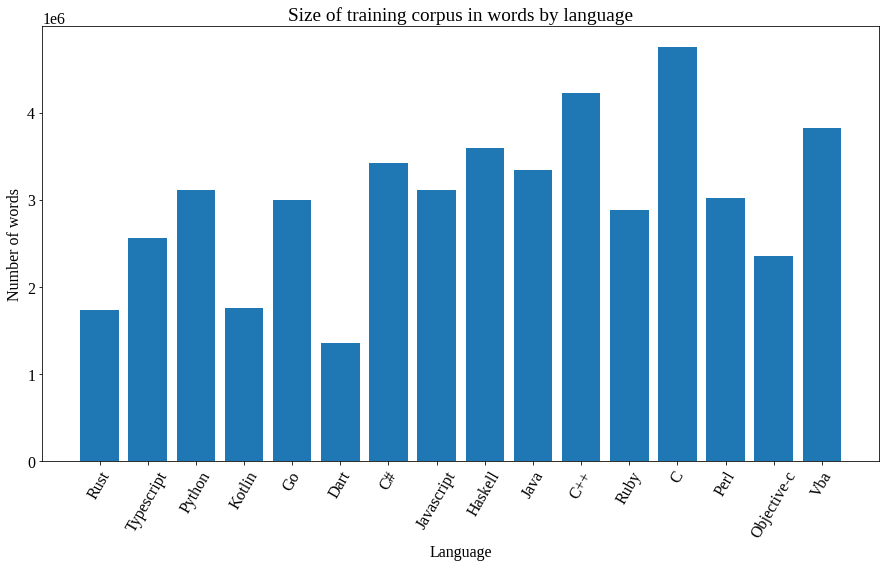

In [10]:
# Corpus size distribution
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.bar(range(len(loved_languages)), [len(corpus) for corpus in train_texts.values()], tick_label=[x.capitalize() for x in train_texts])
ax.tick_params(axis="x", rotation=60)
ax.set_title("Size of training corpus in words by language")
ax.set_xlabel("Language")
ax.set_ylabel("Number of words")

With the data split into training and validation, the classifier can be constructed.
The training consists of building a vocabulary $v$ that maps words to TF-IDF scores for each training document.
Then, given a cleaned text, the classifier calculates a score $S_l$ for each language $l$ using the formula
\begin{equation*}
    S_l=\sum_{\text{word}\,\in\,\text{text}} \begin{cases}
        v_l(\text{word}) &\text{if word}\in v_l\\
        0 &\text{otherwise}
    \end{cases}
\end{equation*}
The language $l^*$ that maximizes $S_l$ is then predicted:
\begin{equation*}
    l^* = \mathop{\operatorname{argmax}}\limits_{l\,\in\,\text{languages}} S_l
\end{equation*}
All $v_l$ are constructed as a dictionary of dictionaries - `tfidf` in the code. This dictionary maps languages to their corresponding $v_l$, which again is a dictionary that maps words to TF-IDF values.

In [11]:
# Build classifier using TF-IDF
tfidf = dict()  # { language: { word: TF-IDF score } }
counts = { lang: Counter(train_texts[lang]) for lang in tqdm(loved_languages) }
t = Table()
t.add_header(["Language", "Size of vocabulary"])
for lang in tqdm(loved_languages):
    # Count of each for given language
    c = counts[lang]
    # Calculate TF and IDF
    tf = { word: count / len(train_texts[lang]) for word, count in c.items() }
    idf = {
        word: np.log(
            len(c) /\
            (1 + sum(word in vocab for vocab in counts.values()))
        )
        for word in c
    }
    tfidf[lang] = { word: tf[word] * idf[word] for word in c }
    t.add_row([lang.capitalize(), thousand_seps(tfidf[lang])], [1, 0])
    

def classify(text: str, cleaned=True, tfidf_: dict=None) -> tuple[str, dict]:
    """
    Classify text by TF-IDF scores by summing TF-IDF for every word in every language and selecting language with highest score
    Returns language and probability distribution over all languages
    An optional TF-IDF dict can be given. Default is the tfidf variable
    """
    tfidf_ = tfidf_ or tfidf
    # Make sure text is cleaned
    if not cleaned:
        text = clean(text)
    word_counts = Counter(text.split())
    scores = dict()
    langs = list(tfidf_.keys())
    for lang, word_tfidf in tfidf_.items():
        scores[lang] = 0
        for word, count in word_counts.items():
            scores[lang] += word_tfidf.get(word, 0)
        if scores[lang] == 0:
            scores[lang] = -float("inf")
    # Calculate probability distribution using softmax
    prob = scipy.special.softmax(np.array(list(scores.values())))
    if np.any(np.isnan(prob)):  # In case of no known words
        return None, None
    return langs[prob.argmax()], prob

100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
print(t)

With the vocabularies constructed, the classifier is ready to be evaluated.
These vocabularies are quite large, so in the interest of limiting memory usage, only a subset of them can be used.
This is done by reducing each $v_l$ to only those words that have the $k$ highest scores.
The classifier is validated on the validation set using all $k\in\{1, 10, 10^2, 10^3, 10^4\}$.
We use both raw accuracy and weighted F1 for measuring classification accuracies.

In [12]:
def top(counts: dict, n: int) -> dict:
    """ Takes a dict { key: count } and returns a dict with the n key-count pairs with highest counts """
    n_highest = sorted(counts.values())[-n] if n <= len(counts) else min(counts.values())
    return { key: count for key, count in counts.items() if count >= n_highest }

def get_conf_mat(tfidf_: dict=None):
    """ Get confusion matrix over threads using a given tfidf dict """
    conf_mat = np.zeros((len(loved_languages), len(loved_languages)), dtype=int)
    lang_indices = { lang: i for i, lang in enumerate(loved_languages) }
    for lang, i in lang_indices.items():
        texts = val_texts[lang]
        for words in texts:
            pred, _ = classify(" ".join(words), tfidf_=tfidf_)
            if pred is not None:
                conf_mat[lang_indices[pred], i] += 1
    return conf_mat

def f1(conf_mat: np.ndarray) -> float:
    """ Calculate weighted f1 score for a given confusion matrix """
    per_class = conf_mat.sum(axis=0)  # Number of submissions by class
    # Generate fake true and pred vectors that satisfy conf mat to calculate f1 score
    y_true = np.array(list(itertools.chain(*([i]*per_class[i] for i in range(len(conf_mat))))))
    y_pred = np.zeros_like(y_true)
    idx = 0
    for i in range(len(conf_mat)):  # True class
        for j in range(len(conf_mat)):  # Predicted class
            y_pred[idx:idx+conf_mat[j, i]] = j
            idx += conf_mat[j, i]
    return f1_score(y_true, y_pred, average="weighted")

  0%|          | 0/5 [00:00<?, ?it/s]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 20%|██        | 1/5 [00:09<00:37,  9.46s/it]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 40%|████      | 2/5 [00:19<00:29,  9.98s/it]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 60%|██████    | 3/5 [00:30<00:20, 10.15s/it]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 80%|████████  | 4/5 [00:40<00:10, 10.03s/it]/home/a

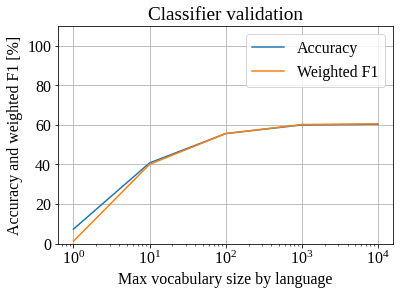

In [13]:
# Get prediction accuracy and weighted f1 for differect vocab sizes
n = 5
number_of_words = np.logspace(0, n-1, n, dtype=int)
accs = list()
f1s = list()
for n_words in tqdm(number_of_words):
    tfidf_ = { lang: top(tfidf[lang], n_words) for lang in tfidf }
    conf_mat = get_conf_mat(tfidf_)
    acc = np.diagonal(conf_mat).sum() / conf_mat.sum()
    accs.append(acc)
    f1s.append(f1(conf_mat))
plt.plot(number_of_words, 100*np.array(accs), label="Accuracy")
plt.plot(number_of_words, 100*np.array(f1s), label="Weighted F1")
plt.ylim([0, 110])
plt.xscale("log")
plt.grid()
plt.title("Classifier validation")
plt.xlabel("Max vocabulary size by language")
plt.ylabel("Accuracy and weighted F1 [%]")
plt.legend()
with open(os.path.join("data", "accs_f1.json"), "w") as f:
    json.dump({
        "number_of_words": number_of_words.tolist(),
        "accs": accs,
        "f1s": f1s,
    }, f)

Given the results, we keep only the 10,000 highest scored words in each vocabulary.

The below confusion matrix shows the distribution of predictions vs true languages given the aforementioned vocabulary size limit.

In [14]:
# Only save for 10k vocab size, as more is redundant
with open(os.path.join("data", "tfidf.json"), "w", encoding="utf-8") as f:
    json.dump({ lang: top(tfidf[lang], 10**4) for lang in tfidf }, f)

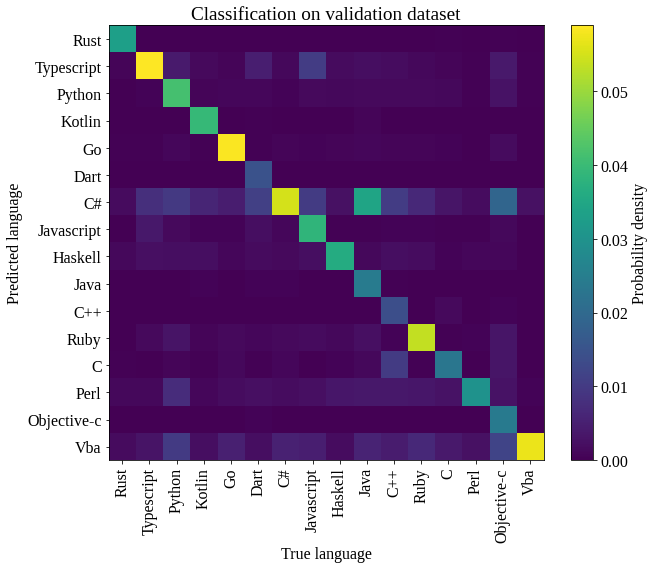

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = ax.imshow(conf_mat/conf_mat.sum())
ax.set_xticks(range(len(loved_languages)))
ax.set_xticklabels([lang.capitalize() for lang in loved_languages])
ax.set_yticks(range(len(loved_languages)))
ax.set_yticklabels([lang.capitalize() for lang in loved_languages])
ax.set_title("Classification on validation dataset")
ax.set_xlabel("True language")
ax.set_ylabel("Predicted language")
ax.tick_params(axis="x", rotation=90)
bar = fig.colorbar(pos)
bar.set_label("Probability density")